In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

%matplotlib inline
pd.options.display.max_columns=None

In [2]:
train_data=pd.read_csv("dc_photos/train/train_data.csv")
train_data.head()

,File name,DC
0,cat-001,0
1,cat-002,0
2,cat-003,0
3,cat-004,0
4,cat-005,0


In [3]:
test_data=pd.read_csv("dc_photos/test/test_data.csv")
test_data.head()

,File name,DC
0,cat-151,0
1,cat-152,0
2,cat-153,0
3,cat-154,0
4,cat-155,0


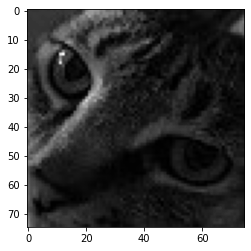

In [4]:
sample_img1=Image.open("dc_photos/train/cat-001.jpg").convert("L")
plt.imshow(sample_img1,cmap="gray")

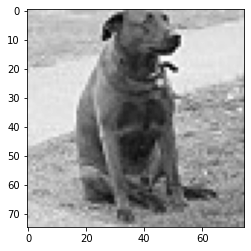

In [5]:
sample_img2=Image.open("dc_photos/train/dog-001.jpg").convert("L")
plt.imshow(sample_img2,cmap="gray")

In [6]:
sample_img1_array=np.array(sample_img1)
sample_img1_array.shape

(75, 75)

In [7]:
train_len=len(train_data)

X_train=np.empty((train_len*4,75,75,1),dtype=np.uint8)
y_train=np.empty(train_len*4,dtype=np.uint8)

for i in range(len(train_data)):
    name=train_data.loc[i,"File name"]
    train_img=Image.open(f"dc_photos/train/{name}.jpg").convert("L")
    train_img=np.array(train_img)
    train_img_f=train_img.reshape(75,75,1)
    X_train[i]=train_img_f
    y_train[i]=train_data.loc[i,"DC"]
    
    train_img_lr=np.fliplr(train_img)
    train_img_lr_f=train_img_lr.reshape(75,75,1)
    X_train[i+train_len]=train_img_lr_f
    y_train[i+train_len]=train_data.loc[i,"DC"]
    
    train_img_ud=np.flipud(train_img_lr)
    train_img_ud_f=train_img_ud.reshape(75,75,1)
    X_train[i+train_len*2]=train_img_ud_f
    y_train[i+train_len*2]=train_data.loc[i,"DC"]
    
    train_img_180=np.rot90(train_img_lr,2)
    train_img_180_f=train_img_180.reshape(75,75,1)
    X_train[i+train_len*3]=train_img_180_f
    y_train[i+train_len*3]=train_data.loc[i,"DC"]

In [8]:
test_len=len(test_data)
X_test=np.empty((test_len,75,75,1),dtype=np.uint8)
y_test=np.empty(test_len,dtype=np.uint8)

for i in range(test_len):
    name=test_data.loc[i,"File name"]
    test_img=Image.open(f"dc_photos/test/{name}.jpg").convert("L")
    test_img=np.array(test_img)
    test_img_f=test_img.reshape(75,75,1)
    X_test[i]=test_img_f
    y_test[i]=test_data.loc[i,"DC"]

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [10]:
print("y_train=", y_train.shape, ", X_train=", X_train.shape)
print("y_valid=", y_valid.shape, ", X_valid=", X_valid.shape)
print("y_test=", y_test.shape, ", X_test=", X_test.shape)

y_train= (840,) , X_train= (840, 75, 75, 1)
y_valid= (360,) , X_valid= (360, 75, 75, 1)
y_test= (100,) , X_test= (100, 75, 75, 1)


In [11]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

In [12]:
model=keras.Sequential()

model.add(Conv2D(16,kernel_size=3,padding="same",strides=1,
                input_shape=(75,75,1,),activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,kernel_size=3,padding="same",strides=1,activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(8,activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(1,activation="sigmoid"))

model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

In [14]:
%time

log=model.fit(X_train,y_train,epochs=100,batch_size=32,verbose=True,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0, patience=50,
                                                     verbose=1)],
             validation_data=(X_valid, y_valid))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Epoch 1/100
27/27 [==============================] - 5s 175ms/step - loss: 19.1234 - accuracy: 0.4964 - val_loss: 0.7075 - val_accuracy: 0.5111
Epoch 2/100
27/27 [==============================] - 4s 165ms/step - loss: 0.7075 - accuracy: 0.4762 - val_loss: 0.7074 - val_accuracy: 0.5111
Epoch 3/100
27/27 [==============================] - 4s 164ms/step - loss: 0.7073 - accuracy: 0.4952 - val_loss: 0.7072 - val_accuracy: 0.4889
Epoch 4/100
27/27 [==============================] - 4s 164ms/step - loss: 0.7069 - accuracy: 0.5048 - val_loss: 0.7065 - val_accuracy: 0.4889
Epoch 5/100
27/27 [==============================] - 4s 165ms/step - loss: 0.7058 - accuracy: 0.5048 - val_loss: 0.7049 - val_accuracy: 0.4889
Epoch 6/100
27/27 [==============================] - 4s 165ms/step - loss: 0.7078 - accuracy: 0.5036 - val_loss: 0.7019 - val_accuracy: 0.4889
Epoch 7/100
27/27 [==============================] - 5s 170ms/step - loss

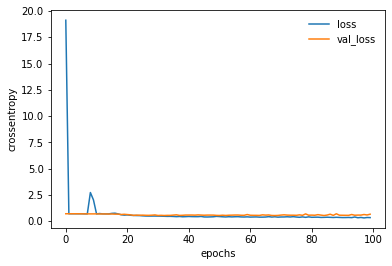

In [15]:
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [16]:
y_pred=model.predict(X_test)

y_pred_cls=(y_pred>0.5).astype("int32")

In [17]:
y_pred

array([[2.48796761e-01],
       [4.46428210e-01],
       [3.49417746e-01],
       [3.47711354e-01],
       [4.04985845e-01],
       [4.08365905e-01],
       [4.03982133e-01],
       [2.84603834e-02],
       [3.79867285e-01],
       [1.19025111e-02],
       [4.03982133e-01],
       [3.96670133e-01],
       [5.04943311e-01],
       [1.88779086e-01],
       [1.91520154e-01],
       [9.24874246e-02],
       [3.43478352e-01],
       [3.98220718e-01],
       [6.74340546e-01],
       [4.71490353e-01],
       [1.87363029e-01],
       [3.22709590e-01],
       [3.98003280e-01],
       [3.88325095e-01],
       [4.03982133e-01],
       [4.03982133e-01],
       [4.03982133e-01],
       [3.98817867e-01],
       [1.12146854e-01],
       [3.82592976e-01],
       [4.85763103e-01],
       [4.03982133e-01],
       [3.99566144e-01],
       [3.53607148e-01],
       [3.69962305e-01],
       [6.28523171e-01],
       [4.88583446e-02],
       [2.74963468e-01],
       [4.03982133e-01],
       [4.03982133e-01],


In [18]:
y_pred_cls

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
    

In [19]:
y_pred_=y_pred_cls.reshape(-1)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        50
           1       0.92      0.94      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

